# Training fetalnav

This notebook shows an example of a training session for the paper:

```bibtex
@inproceedings{toussaint.dlmia.18,
    author = {Toussaint, Nicolas and Khanal, Bishesh and Sinclair, Matthew and Gomez, Alberto and Skelton, Emily and Matthew, Jacqueline and Schnabel, Julia A.},
    title = {Weakly Supervised Localisation for Fetal Ultrasound Images},
    booktitle = {Proceedings of the 4th Workshop on Deep Learning in Medical Image Analysis},
    year = {2018}
}
```

## Requirements

* Cuda >= 8
* Python>=3.5
* PyTorch: `pip3 install torch torchvision`
* Other Packages: [torchnet](https://github.com/pytorch/tnt), [spn](https://github.com/yeezhu/SPN.pytorch)
* [fetalnav](https://github.com/ntoussaint/fetalnav)

# Imports and definitions

In [1]:
%matplotlib inline

# general
import argparse
import os
import sys
import numpy as np
from matplotlib import pyplot as plt

# warnings
import warnings
warnings.filterwarnings('ignore', '.*deprecated.*')

# tensorboardX
from tensorboardX import SummaryWriter

# torch - torchvision
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as torchtransforms

# transforms
from fetalnav.transforms import itk_transforms as itktransforms
from fetalnav.transforms import tensor_transforms as tensortransforms
# dataset
from fetalnav.datasets.itk_metadata_classification import ITKMetaDataClassification
# models
from fetalnav.models.spn_models import *

# engine
import engine as torchengine


def define_transforms(hp):

    keys=('spacing', 'aspect_ratio', 'image_size','rescale_interval','flip')
    for k in keys:
        assert(k in hp.keys()), 'hyper parameters should contain the key \'{}\''.format(k)

    ## create transformation and data augmentation schemes

    # spacing is arbitrary
    resample = itktransforms.Resample(new_spacing=hp['spacing'])
    # transform an ITK image into a numpy array
    tonumpy = itktransforms.ToNumpy(outputtype='float')
    # transform a numpy array into a torch tensor
    totensor = torchtransforms.ToTensor()
    # crop to an aspect ratio
    crop = tensortransforms.CropToRatio(outputaspect=hp['aspect_ratio'])
    # padd to an aspect ratio
    padd = tensortransforms.PaddToRatio(outputaspect=hp['aspect_ratio'])
    # resize image to fixed size
    resize = tensortransforms.Resize(size=hp['image_size'], interp='bilinear')
    # rescale tensor to  interval
    rescale = tensortransforms.Rescale(interval=hp['rescale_interval'])
    # flip image in the y axis
    flip = tensortransforms.Flip(axis=2) if hp['flip'] else None

    # transforms to apply when learning
    train_transform = torchtransforms.Compose(
                        [resample,
                         tonumpy,
                         totensor,
                         crop,
                         resize,
                         rescale,
                         flip])

    # transforms to apply when validating
    val_transform = torchtransforms.Compose(
                            [resample,
                             tonumpy,
                             totensor,
                             crop,
                             resize,
                             rescale])

    hp['train_transform'] = train_transform
    hp['val_transform'] = val_transform

    return hp


def define_loaders(hp):

    keys=('datadir', 'train_transform','val_transform', 'batch_size', 'num_workers')
    for k in keys:
        assert(k in hp.keys()), 'hyper parameters should contain the key \'{}\''.format(k)

    datadir = hp['datadir']
    train_transform = hp['train_transform']
    val_transform = hp['val_transform']

    # load datasets
    train_dataset = ITKMetaDataClassification(root=datadir, mode='train',
                                              transform=train_transform)
    val_dataset   = ITKMetaDataClassification(root=datadir, mode='validate',
                                              transform=val_transform)

    # estimate the samples' weights
    train_cardinality = train_dataset.get_class_cardinality()
    val_cardinality = val_dataset.get_class_cardinality()
    train_sample_weights = torch.from_numpy(train_dataset.get_sample_weights())
    val_sample_weights = torch.from_numpy(val_dataset.get_sample_weights())

    print('')
    print('train-dataset: ')
    for idx, c in enumerate(train_dataset.get_classes()):
        print('{}: \t{}'.format(train_cardinality[idx], c))
    print('')
    print('validate-dataset: ')
    for idx, c in enumerate(val_dataset.get_classes()):
        print('{}: \t{}'.format(val_cardinality[idx], c))
    print('')

    # class labels
    classes_train = train_dataset.get_classes()
    classes_val = val_dataset.get_classes()

    assert(classes_train == classes_val), 'classes differ between train and validation sets'
    classes = classes_train
    del classes_train, classes_val

    # create samplers weighting samples according to the occurence of their respective class
    train_sampler = torch.utils.data.sampler.WeightedRandomSampler(train_sample_weights,
                                                                   int(np.min(train_cardinality)),
                                                                   replacement=True)

    # create data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=hp['batch_size'], shuffle=False,
                                               num_workers=hp['num_workers'], sampler=train_sampler)

    val_loader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=hp['batch_size'], shuffle=False,
                                             num_workers=hp['num_workers'])

    hp['train_loader'] = train_loader
    hp['val_loader'] = val_loader

    hp['classes'] = classes

    return hp

def define_logging(hp):

    keys=('coordinate_system','arch', 'learning_rate', 'batch_size', 'aspect_ratio')
    for k in keys:
        assert(k in hp.keys()), 'hyper parameters should contain the key \'{}\''.format(k)

    # define output log directory
    p='cs={}-m={}-lr={}-bs={}-spn={}-aspect={}'.format(hp['coordinate_system'],
                                                       hp['arch'],
                                                       hp['learning_rate'],
                                                       hp['batch_size'],
                                                       1,
                                                       hp['aspect_ratio']
                                                      )
    p=os.path.join('logs', p)
    hp['save_model_path'] = p
    hp['Logger'] = SummaryWriter(log_dir=p)
    return hp

def define_model(hp):

    keys=('arch', 'classes', 'learning_rate', 'momentum', 'weight_decay')
    for k in keys:
        assert(k in hp.keys()), 'hyper parameters should contain the key \'{}\''.format(k)

    print('asking for model: {}'.format(hp['arch']))
    num_classes = len(hp['classes'])

    model = None

    if   hp['arch'] == 'resnet18':
        model = resnet18_sp(num_classes, num_maps=512, in_channels=1)
    elif hp['arch'] == 'resnet34':
        model = resnet34_sp(num_classes, num_maps=512, in_channels=1)
    elif hp['arch'] == 'vgg13':
        model = vgg13_sp(num_classes, batch_norm=False, num_maps=512, in_channels=1)
    elif hp['arch'] == 'vgg13_bn':
        model = vgg13_sp(num_classes, batch_norm=True, num_maps=512, in_channels=1)
    elif hp['arch'] == 'vgg16':
        model = vgg16_sp(num_classes, batch_norm=False, num_maps=512, in_channels=1)
    elif hp['arch'] == 'vgg16_bn':
        model = vgg16_sp(num_classes, batch_norm=True, num_maps=512, in_channels=1)
    elif hp['arch'] == 'alexnet':
        model = alexnet_sp(num_classes, num_maps=512, in_channels=1)

    print(model)

    criterion = nn.MultiLabelSoftMarginLoss()
    optimizer = torch.optim.SGD(model.parameters(),
                                lr=hp['learning_rate'],
                                momentum=hp['momentum'],
                                weight_decay=hp['weight_decay'])
    hp['model'] = model
    hp['criterion'] = criterion
    hp['optimizer'] = optimizer

    return hp

def explore_dataset(hp):

    keys=('train_loader', 'classes', 'batch_size')
    for k in keys:
        assert(k in hp.keys()), 'hyper parameters should contain the key \'{}\''.format(k)

    train_loader = hp['train_loader']

    # show an image
    def imshow(img):
        npimg = img.numpy()
        return plt.imshow(np.transpose(npimg, (1, 2, 0)))

    dataiter = iter(train_loader)
    for i, (images, labels) in enumerate(train_loader):
        images, labels = dataiter.next()
        break
    # show a minibatch
    plt.figure(0, figsize=(3*hp['batch_size'],3))
    imshow(torchvision.utils.make_grid([im for im in images]))
    plt.show()
    print('     '+'           '.join('%5s' % hp['classes'][np.argmax(labels[j].numpy())] for j in range(hp['batch_size'])))


def define_dictionaries(variables):
    engine_state = {
        'use_gpu': torch.cuda.is_available(),
        'evaluate': False,
        'start_epoch': 0,
        'max_epochs': 30,
        'epoch_step':[10,20],
        'maximize': True,
        'resume': None,
        'use_pb': True,
    }

    p = {
        'image_size': [224, 224],
        'spacing': [.5, .5, 1.],
        'flip': True,
        'rescale_interval': [0,1],
        'batch_size': 6,
        'num_workers': 8,
        'learning_rate': 0.01,
        'momentum': 0.9,
        'weight_decay': 5e-4,
        'arch': 'resnet18',
        'coordinate_system': 'cart',
        'aspect_ratio': 1.,
    }

    print('Initializing state...')
    p.update(engine_state)

    print('Updating variables...')
    p.update(variables)

    print('Defining transforms...')
    p = define_transforms(p)

    print('Defining dataset...')
    p = define_loaders(p)

    print('Defining model...')
    p = define_model(p)

    print('Defining logging...')
    p = define_logging(p)

    return p

def learning(hp):

    keys=('model', 'train_loader', 'val_loader', 'criterion', 'optimizer', 'save_model_path')
    for k in keys:
        assert(k in hp.keys()), 'hyper parameters should contain the key \'{}\''.format(k)

    model = hp['model']
    train_loader = hp['train_loader']
    val_loader = hp['val_loader']
    criterion = hp['criterion']
    optimizer = hp['optimizer']

    # instantiate a MultiLabelMAP engine
    engine = torchengine.MultiLabelMAPEngine(hp)
    print(hp['save_model_path'])
    # learn
    engine.learning(model, criterion, train_loader, val_loader, optimizer)



# DataSet directory

Use your own dataset there, containing a subdirectory **'train'** and within it a labelled set of images, itk-compatible, containing the key **Label** in the metadata dictionary

In [2]:
datadir = # <directory containing a subdirectory 'train' with itk-readable image files>

# Define the hyperparameters using this dictionary

Initializing state...
Updating variables...
Defining transforms...
Defining dataset...

train-dataset: 
13639: 	Abdomen
10030: 	Background
18320: 	Head
8810: 	Limbs
5581: 	Placenta
3960: 	Spine
25419: 	Thorax

validate-dataset: 
2581: 	Abdomen
2657: 	Background
6929: 	Head
2807: 	Limbs
500: 	Placenta
2020: 	Spine
6835: 	Thorax

Defining model...
asking for model: vgg16_bn
SPNetWSL(
  (features): Sequential(
    (0): Conv2d (1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (7): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (9): ReLU(inplace)
    (10): Conv2d (128, 128, ker

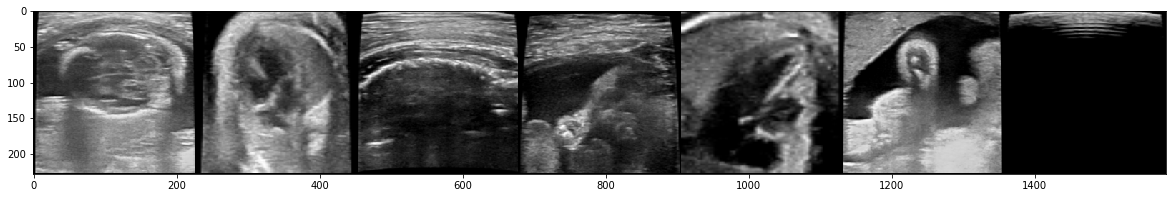

      Head           Thorax           Spine           Limbs           Thorax           Limbs           Background


In [3]:
state = {'batch_size': 7,
         'max_epochs': 30,
         'image_size': [224] * 2,
         'evaluate': False,
         'resume': None,
         'learning_rate': 0.05,
         'epoch_step': range(0, 30, 5),
         'momentum': 0.6,
         'weight_decay':5e-4,
         'datadir': datadir,
         'arch': 'vgg16_bn',
         'save_model_path': '.',
         'coordinate_system':'pol',
         'aspect_ratio': 1.5
         }
state = define_dictionaries(state)

explore_dataset(state)


# Start the training

In [ ]:
learning(state)

## About this notebook

written by Nicolas Toussaint

Contact: <nicolas.toussaint@gmail.com>